### Install the dependencies you need

(Only for testing purposes)

In [35]:
# !pip install awswrangler
# !pip install lightgbm
# !pip install palmerpenguins
# !pip install seaborn

## 1. Preparation

In [1]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

import awswrangler as wr
import pandas as pd
import sklearn.model_selection
import os

### This is an object that represents the IAM role that we are currently assigned. When we construct
### and launch the training job later we will need to tell it what IAM role it should have. Since our
### use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

prefix = 'LightGBM_Framework'
bucket = "jas-sagemakerstudio-gitlab"
### In this case, we don't need to define the next two variables
region = boto3.Session().region_name

# S3 Arguments for KMS Encryption
ExtraArgs = {"ServerSideEncryption": "aws:kms", 
             "SSEKMSKeyId": "alias/aws/s3"}

### This is an object that represents the SageMaker session that we are currently operating in. This
### object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session(default_bucket=bucket)
role = sagemaker.get_execution_role()
mclient = boto3.Session().client('sagemaker')


Couldn't call 'get_role' to get Role ARN from role name SagemakerStudio to get Role path.
Couldn't call 'get_role' to get Role ARN from role name SagemakerStudio to get Role path.


## 2. Load Dataset

For an example purpose, we use the Boston dataset. This means you will have a regression problem, which affects the objective metric of the XGBoost model ahead.

**Note:** On this demo, the data is being uploaded into an S3 bucket, which would be the case in a real life scenario. The chosen data format is parquet: we'll need to take this into account on the script.

In [2]:
# # Load Boston Dataset
# from sklearn import datasets

# boston_data = datasets.load_boston()
# df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
# df_boston['target'] = pd.Series(boston_data.target)
# df_boston.head()

In [3]:
# len(df_boston)

In [4]:
from palmerpenguins import load_penguins
penguins = load_penguins()
penguins.tail()

species island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
339  Chinstrap  Dream            55.8           19.8              207.0   
340  Chinstrap  Dream            43.5           18.1              202.0   
341  Chinstrap  Dream            49.6           18.2              193.0   
342  Chinstrap  Dream            50.8           19.0              210.0   
343  Chinstrap  Dream            50.2           18.7              198.0   

     body_mass_g     sex  year  
339       4000.0    male  2009  
340       3400.0  female  2009  
341       3775.0    male  2009  
342       4100.0    male  2009  
343       3775.0  female  2009

In [5]:
X_inputs = penguins.drop(['species'], axis=1)

# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.
Y_labels = pd.DataFrame(penguins["species"])

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_inputs, Y_labels, test_size = 0.15)

# This is our local data directory. We need to make sure that it exists.
data_dir = './data/model_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.

# pd.concat([Y_val, X_val], axis=1).to_parquet(os.path.join(data_dir, 'validation.parquet'))
pd.concat([Y_train, X_train], axis=1).to_parquet(os.path.join(data_dir, 'train.parquet'))
pd.concat([Y_test, X_test], axis=1).to_parquet(os.path.join(data_dir, 'test.parquet'))

In [6]:
data = pd.read_parquet(f"{data_dir}/train.parquet").dropna()

In [7]:
y = data.iloc[:, 0:1]
y.head(3)

species
29      Adelie
282  Chinstrap
32      Adelie

In [8]:
x = data.iloc[:, 1:]
x.head(3)

island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
29   Biscoe            40.5           18.9              180.0       3950.0   
282   Dream            46.1           18.2              178.0       3250.0   
32    Dream            39.5           17.8              188.0       3300.0   

        sex  year  
29     male  2007  
282  female  2007  
32   female  2007

In [9]:
x = pd.get_dummies(x, drop_first=True)

In [10]:
x.head(2)

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  year  \
29             40.5           18.9              180.0       3950.0  2007   
282            46.1           18.2              178.0       3250.0  2007   

     island_Dream  island_Torgersen  sex_male  
29              0                 0         1  
282             1                 0         0

In [11]:
y.head()

species
29      Adelie
282  Chinstrap
32      Adelie
316  Chinstrap
99      Adelie

In [38]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column

y['species'] = labelencoder.fit_transform(y['species'])
y

species
303        1
163        2
322        1
220        2
87         0
..       ...
22         0
139        0
187        2
194        2
96         0

[283 rows x 1 columns]

<AxesSubplot:>

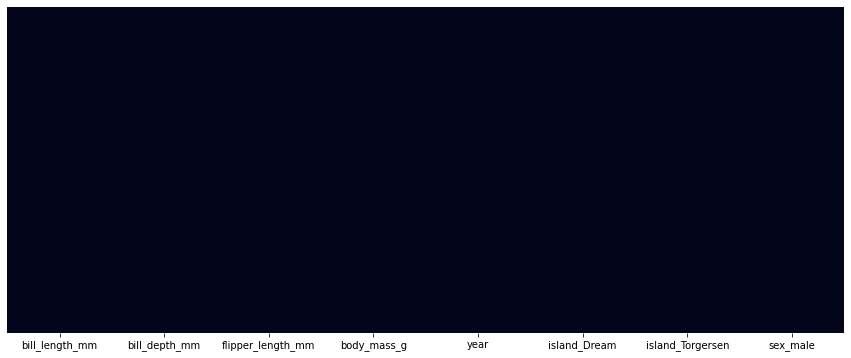

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (15,6))
sns.heatmap(x.isnull(),yticklabels=False,cbar=False)

In [13]:
import argparse
import joblib
from lightgbm import LGBMClassifier
import os
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# from package.data import schemas, datasets

In [14]:
hyperparameters = {
    "tree_n_estimators": 42,
    "tree_max_depth": 2,
    "tree_min_child_samples": 1,
    "tree_boosting_type": "dart",
    "tree_num_leaves": 31
}

In [15]:
hyperparameters

{'tree_n_estimators': 42,
 'tree_max_depth': 2,
 'tree_min_child_samples': 1,
 'tree_boosting_type': 'dart',
 'tree_num_leaves': 31}

In [22]:
num_cols = list(x._get_numeric_data().columns)
cat_cols = [i for i in x.columns if i not in num_cols]
cat_cols

['island', 'sex']

In [16]:
classifier = LGBMClassifier(
    max_depth=hyperparameters["tree_max_depth"],
    num_leaves=hyperparameters["tree_num_leaves"],
    boosting_type=hyperparameters["tree_boosting_type"],
    min_child_samples=hyperparameters["tree_min_child_samples"],
    n_estimators=hyperparameters["tree_n_estimators"],
    )

In [18]:
classifier.fit(x, y.values.ravel())

LGBMClassifier(boosting_type='dart', max_depth=2, min_child_samples=1,
               n_estimators=42)

In [19]:
test_data = pd.read_parquet(f"{data_dir}/test.parquet").dropna()

In [20]:
test_data.head(2)

species  island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
102     Adelie  Biscoe            37.7           16.0              183.0   
326  Chinstrap   Dream            48.1           16.4              199.0   

     body_mass_g     sex  year  
102       3075.0  female  2009  
326       3325.0  female  2009

In [21]:
x_test = test_data.iloc[:, 1:]
x_test = pd.get_dummies(x_test, drop_first=True)

In [22]:
x_test.head(3)

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  year  \
102            37.7           16.0              183.0       3075.0  2009   
326            48.1           16.4              199.0       3325.0  2009   
30             39.5           16.7              178.0       3250.0  2007   

     island_Dream  island_Torgersen  sex_male  
102             0                 0         0  
326             1                 0         0  
30              1                 0         0

In [23]:
y_test = test_data.iloc[:, 0:1]

In [24]:
# y_test.values

In [31]:
classifier.predict(x_test)

array(['Adelie', 'Chinstrap', 'Adelie', 'Gentoo', 'Gentoo', 'Gentoo',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Gentoo', 'Adelie', 'Adelie', 'Adelie', 'Chinstrap', 'Adelie',
       'Gentoo', 'Chinstrap', 'Gentoo', 'Gentoo', 'Gentoo', 'Gentoo',
       'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie', 'Adelie',
       'Gentoo', 'Adelie', 'Gentoo', 'Gentoo', 'Adelie', 'Adelie',
       'Adelie', 'Chinstrap', 'Adelie', 'Chinstrap', 'Chinstrap',
       'Adelie', 'Gentoo', 'Gentoo', 'Adelie', 'Gentoo', 'Adelie',
       'Gentoo', 'Gentoo', 'Gentoo'], dtype=object)

In [26]:
from sklearn.model_selection import cross_val_score

def log_cross_val_auc(clf, X, y, cv_splits, log_prefix):
    cv_auc = cross_val_score(clf, X, y, cv=cv_splits, scoring='f1')
    cv_auc_mean = cv_auc.mean()
    cv_auc_error = cv_auc.std() * 2
    
    print(f"initial: {cv_auc}\nMean: {cv_auc_mean}\nError: {cv_auc_error}")

In [ ]:
log_cross_val_auc(classifier, x, y, 3, "'train'")

In [62]:
y

species
323  Chinstrap
287  Chinstrap
36      Adelie
202     Gentoo
53      Adelie
..         ...
139     Adelie
257     Gentoo
152     Gentoo
290  Chinstrap
249     Gentoo

[284 rows x 1 columns]

In [39]:
cross_val_score(classifier, x, y.values.ravel(), cv=3, scoring='recall_weighted')

array([0.96842105, 0.96808511, 0.9787234 ])

In [53]:
import sklearn

sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [30]:
y

species
29      Adelie
282  Chinstrap
32      Adelie
316  Chinstrap
99      Adelie
..         ...
307  Chinstrap
157     Gentoo
204     Gentoo
0       Adelie
203     Gentoo

[283 rows x 1 columns]

In [6]:
train_location = session.upload_data(os.path.join(data_dir, 'train.parquet'),
                                     key_prefix = prefix,
                                     bucket = bucket, 
                                     extra_args = ExtraArgs)

test_location = session.upload_data(os.path.join(data_dir, 'test.parquet'), 
                                    key_prefix = prefix, 
                                    bucket = bucket, 
                                    extra_args = ExtraArgs)

print(f"Train Set Location: {train_location}")
print(f"Test Set Location: {test_location}")

Train Set Location: s3://jas-sagemakerstudio-gitlab/LightGBM_Framework/train.parquet
Test Set Location: s3://jas-sagemakerstudio-gitlab/LightGBM_Framework/test.parquet


## 3. Build the XGBoost Container

This is where you define the container properties and environment where the script is going to run.
We setup initial hyperparameters, although, it is preferable to run several experiments through a Hyperparameter Tuning job.

In [ ]:
hyperparams = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "reg:squarederror",
    "num_round": "50",
    "verbosity": "2", 
    "tree_method": "hist",
    "eval_metric": "mae"
}

In [ ]:
instance_type = "ml.m5.large"
output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, 'xgb_framework')
content_type = "parquet"

print(output_path)

#### Check your script before you create the container

In [ ]:
!pygmentize ./train_script/XGBoostTrain.py

#### Container Build-up

In [ ]:
# Open Source distributed script mode
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost.estimator import XGBoost

boto_session = boto3.Session(region_name=region)
b3_session = boto3.Session(region_name=region)

script_path = 'XGBoostTrain.py'

xgb_script_mode_estimator = XGBoost(
    source_dir="train_script",
    entry_point=script_path,
    framework_version='1.2-1', # Note: framework_version is mandatory
    hyperparameters=hyperparams,
    role=role,
    session=session,  
    instance_count=1,
    instance_type=instance_type,
    output_path=output_path,
    output_kms_key="alias/aws/s3" # Note: add KMS alias if yout S3 bucket has kms service side encryption
)

#### Define data inputs on Running instances

In [ ]:
train_input = sagemaker.inputs.TrainingInput(s3_data = train_location, content_type = 'parquet')
test_input = sagemaker.inputs.TrainingInput(s3_data = test_location, content_type = 'parquet')

In [ ]:
train_input.config

In [ ]:
test_input.config

#### Apply the container .fit method to check if your running script is sound

In [ ]:
xgb_script_mode_estimator.fit({'train': train_input, 'test': test_input})

### Evaluation Metrics (from the XGBoost Library)

Evaluation metrics for validation data, a default metric will be assigned according to objective (rmse for regression, and logloss for classification, mean average precision for ranking)
User can add multiple evaluation metrics. Python users: remember to pass the metrics in as list of parameters pairs instead of map, so that latter eval_metric won’t override previous one

The choices are listed below:

- **rmse**: root mean square error


- **rmsle**: root mean square log error: 1𝑁[𝑙𝑜𝑔(𝑝𝑟𝑒𝑑+1)−𝑙𝑜𝑔(𝑙𝑎𝑏𝑒𝑙+1)]2‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾√. Default metric of reg:squaredlogerror objective. This metric reduces errors generated by outliers in dataset. But because log function is employed, rmsle might output nan when prediction value is less than -1. See reg:squaredlogerror for other requirements.


- **mae**: mean absolute error


- **mape**: mean absolute percentage error


- **mphe**: mean Pseudo Huber error. Default metric of reg:pseudohubererror objective.


- **logloss**: negative log-likelihood


- **error**: Binary classification error rate. It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.


- **error@t**: a different than 0.5 binary classification threshold value could be specified by providing a numerical value through ‘t’.


- **merror**: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).


- **mlogloss**: Multiclass logloss.


- **auc**: Receiver Operating Characteristic Area under the Curve. Available for classification and learning-to-rank tasks:
     - When used with binary classification, the objective should be binary:logistic or similar functions that work on probability.
     - When used with multi-class classification, objective should be multi:softprob instead of multi:softmax, as the latter doesn’t output probability. Also the AUC is calculated by 1-vs-rest with reference class weighted by class prevalence.
     - When used with LTR task, the AUC is computed by comparing pairs of documents to count correctly sorted pairs. This corresponds to pairwise learning to rank. The implementation has some issues with average AUC around groups and distributed workers not being well-defined.
     - On a single machine the AUC calculation is exact. In a distributed environment the AUC is a weighted average over the AUC of training rows on each node - therefore, distributed AUC is an approximation sensitive to the distribution of data across workers. Use another metric in distributed environments if precision and reproducibility are important.
     - If input dataset contains only negative or positive samples the output is NaN.


- **aucpr**: Area under the PR curve. Available for binary classification and learning-to-rank tasks.


- **ndcg**: Normalized Discounted Cumulative Gain


- **map**: Mean Average Precision


- **ndcg@n, map@n**: ‘n’ can be assigned as an integer to cut off the top positions in the lists for evaluation.


- **ndcg-, map-, ndcg@n-, map@n-**: In XGBoost, NDCG and MAP will evaluate the score of a list without any positive samples as 1. By adding “-” in the evaluation metric XGBoost will evaluate these score as 0 to be consistent under some conditions.


- **poisson-nloglik**: negative log-likelihood for Poisson regression


- **gamma-nloglik**: negative log-likelihood for gamma regression


- **cox-nloglik**: negative partial log-likelihood for Cox proportional hazards regression


- **gamma-deviance**: residual deviance for gamma regression


- **tweedie-nloglik**: negative log-likelihood for Tweedie regression (at a specified value of the tweedie_variance_power parameter)


- **aft-nloglik**: Negative log likelihood of Accelerated Failure Time model. See Survival Analysis with Accelerated Failure Time for details.


- **interval-regression-accuracy**: Fraction of data points whose predicted labels fall in the interval-censored labels. Only applicable for interval-censored data. See Survival Analysis with Accelerated Failure Time for details.

## 4. Setup Hyperparameter Tuning Job

In [ ]:
## To be continued...

In [ ]:
hyperparams = {
    "max_depth": 5,
    "eta": 0.2,
    "gamma": 4,
    "min_child_weight": 6,
    "subsample": 0.7,
    "objective": "reg:squarederror",
    "num_round": 50,
    "verbosity": 2,
#     "num_round": 5, 
#     "base_score": 0.5,
    "tree_method": "hist",
#     "eval_metric": "mae"
}